<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><a href="https://www.kaggle.com/datasets/adityakadam1/footwear">Reconnaissance des Chaussures</a></div>
     </th>
     <th><img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/chaussures.png" width="96"></th>
 </tr>
</table>



**Reconnaissance des Chaussures**<br>
Le jeu de données contient **3 000** images de fleurs étiquetées en **3** classes.

<table>
    <tr>                                                                                   
         <th  style="text-align:left;background-color:#053061;color:white;">Valeur</th>
         <th  style="text-align:left;background-color:#053061;color:white;">Nom classe</th>
     </tr>
    <tr>
        <th  style="text-align:left">0</th>
        <th  style="text-align:left">Botte</th>
    </tr>
    <tr>
        <th  style="text-align:left">1</th>
        <th  style="text-align:left">Chaussure</th>
    </tr>
</table>


> https://www.larousse.fr/dictionnaires/francais/inf%C3%A9rence/42907<br><br>

>> **inférence** : Opération par laquelle on passe d'une assertion considérée comme vraie à une autre assertion au moyen d'un système de règles qui rend cette deuxième assertion également vraie.<br>

>> **Inférence statistique** : Ensemble des méthodes permettant de formuler en termes probabilistes un jugement sur une population à partir des résultats observés sur un échantillon extrait au hasard de cette population.<br>
 

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du document</div></b>

In [25]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Import libriries </div></b>

In [26]:
import numpy as np, pandas as pd, seaborn as sns, warnings, os, sys, pickle, time
from matplotlib import pyplot as plt
from datetime import datetime as dt

import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)

In [27]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import max_norm

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.preprocessing import label_binarize
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                            precision_score, recall_score, f1_score, fbeta_score, jaccard_score, \
                            precision_recall_curve, average_precision_score, balanced_accuracy_score, \
                            classification_report,roc_auc_score

tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)

In [28]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       tf.keras.__version__, 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.17.0	CUDA True	GPU True	XLA True
Keras		 : 3.6.0
Pandas		 : 2.2.2
NumPy		 : 1.26.4


# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation des GPUs presents</div></b>

In [29]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))

Le système est initialisé avec 1 GPUs


# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Outils du document</div></b>

In [30]:
palette = [
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]

In [31]:
nom_projet                = "07-L'apprentissage et rappels d’exécution--modèle CNN-binaire--Chaussures-TFRecods"
repertoireProjet          = os.getcwd()
repertoireEnregistrement  = repertoireProjet +'/'+nom_projet+ '/repertoire.images'
repertoireSauvegardes     = repertoireProjet +'/'+nom_projet+ '/repertoire.sauvegardes'

def controleExistenceRepertoire(directory, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(directory)
    if path_exists:
        if not os.path.isdir(directory):
            raise Exception("Trouvé le nom "+directory+" mais c'est un fichier, pas un répertoire")
            return False
        return True
    if create_if_needed:
        os.makedirs(directory)
        
controleExistenceRepertoire(repertoireEnregistrement)
controleExistenceRepertoire(repertoireSauvegardes)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    plt.savefig(os.path.join(repertoireEnregistrement,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')
    
def sauvegarderModelPoids(model, fichierPoids, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez les poids du modèle Keras."""
    if fichierPoids != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichierPoids))
        model.save_weights(nomFichier)

def sauvegarderModel(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez le modèle Keras."""
    if fichier != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
        model.save(nomFichier)

def lectureModelPoids(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Si le fichier existe, il est chargé et retourne True, sinon retourne False."""
    nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
    if os.path.exists(nomFichier):
        if os.path.isfile(nomFichier):
            model.load_weights(nomFichier)
            return True
    return False

def sauvegardeHistorique(model,
                         repertoireSauvegardes,
                         nomSauvegarde='one_hidden_layer_history_batch_size_1'):

    history = pd.DataFrame( model.history)
    history.reset_index(inplace=True)
    history.rename(columns={'index':'epoch'},inplace=True)
    history.to_parquet(os.path.join(repertoireSauvegardes,f'{nomSauvegarde}.gzip'),compression='gzip', engine='pyarrow') 
    return history


def afficheHistoriqueEntrainement(history, palette, nom):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(48,16));
    markersize = 8
    linewidth=2
    
    graph = sns.lineplot(x='epoch', 
                         y='accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='val_accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
        
    ax[0].set_title(f'Accuracy {nom}', fontproperties=fm.FontProperties(size=32))
    
    graph = sns.lineplot(x='epoch', 
                         y='loss',  
                         data=history,
                         ax=ax[1],      
                         label='loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_loss',  
                         data=history,
                         ax=ax[1],      
                         label='val_loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    ax[1].set_title(f'Loss {nom}', fontproperties=fm.FontProperties(size=32))
    
    sauvegarderImage(f'afficheHistoriqueEntrainement-{nom}')



def afficheMatriceConfusion(observations,predictions,dictLabels):
    plt.figure(figsize=(8,8))
    sns.set(font_scale=1.5)
    sns.heatmap(pd.crosstab(observations,predictions), 
                fmt= '.0f',
                linewidths=0.3,
                #vmax=1.0, 
                square=True, 
                cmap=plt.cm.Blues,
                linecolor='white', 
                annot=True,
                cbar=False,
                xticklabels=dictLabels.values(), 
                yticklabels=dictLabels.values()
               );
    plt.xlabel('Observations', fontsize = 18);
    plt.ylabel('Prédictions', fontsize = 18);
    sauvegarderImage('afficheMatriceConfusion')

def executeApprentissageChoixClassifieurs(model,
                                          X_test,
                                          y_test,
                                          label_dict,
                                          couleurs,
                                          nom_essai = 'initial'
                                         ):
    
    def afficheCourbes(vraisPositifs,fauxPositifs,aucROCt,precisions,sensibilites,avgPrecRec,nbClasses,lw,label_dict):
        plt.figure(figsize=(24, 24));
        for i, color in zip(range(nbClasses), palette):
            plt.plot(fauxPositifs[i], vraisPositifs[i], color=color, lw=lw,
                     label=' ' + label_dict[i] + ' (AUC = {1:0.8f})'
                                                             ''.format(i, aucROCt[i]))
    
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Taux de faux Positifs-(1 - Spécificité) = VN / (FP + VN)',size=18)
        plt.ylabel('Taux de vrais positifs-Sensibilité = VP / (VP + FN)',size=18)
        plt.title('Courbe ROC (Receiver Operating Caracteristic) -- ',size=20)
        plt.legend(loc="lower right"); #, fontsize='large'
        sauvegarderImage('Courbe ROC')
        
        plt.figure(figsize=(24,24));
    
        f_scores = np.linspace(0.2, 0.9, num=8)
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
        for i, color in zip(range(nbClasses), palette):
            plt.step(sensibilites[i], 
                         precisions[i], 
                         where='post', 
                         color=color, 
                         lw=lw, 
                         label=f"{label_dict[i]}(APR = {avgPrecRec[label_dict[i]]:0.8f})"
                    )
            plt.fill_between(sensibilites[i], precisions[i], step='post', alpha=0.05)            
    
            # plt.plot(fauxPositifs[i], vraisPositifs[i], color=color, lw=lw,
            #          label=' ' + label_dict[i] + ' (AUC = {1:0.8f})'
            #                                                  ''.format(i, aucROCt[i]))        
    
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])        
        plt.xlabel('Sensibilité/Rappel(Recall) = VP / (VP + FN)',size=18)
        plt.ylabel('Précision = VP / (VP + FP)',size=18)        
        plt.title('Courbe Précision-Rappel',size=20)
        plt.legend(loc="lower right") # , fontsize = 'large'
        sauvegarderImage('Courbe Précision-Rappel')
    
    cvF1, cvF1SD, cvAccuracy, cvAccSD, aucROC, avgPrecRec, accuracy, balanced_accuracy, logloss, hammingloss, precision, sensibilite, \
    f1, f2, f05, jaccard, vrais_negatifs, faux_positifs, faux_negatifs, vrais_positifs, total_positifs, aucROCtn = \
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(),\
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    #
    oneloss, precision_micro, precision_macro, precision_weighted, \
    sensibilite_macro, sensibilite_micro, sensibilite_weighted, \
    f1_micro, f1_macro, f1_weighted,f2_micro,f2_macro,f2_weighted,f05_micro,f05_macro,f05_weighted = \
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), \
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    
    fauxPositifs, vraisPositifs, precisions, sensibilites, aucROCt, pr_auc, tauxROC, tauxPR = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()        
    
    
    lw = 1
    # couleurs    = sns.hls_palette(len(classifieursDict.keys()), l=.4, s=.9)
    nbClasses   = len(dictLabels.keys())
    listClasses = list(dictLabels.keys())
    
    y_testA  = label_binarize(y_test, classes=listClasses)
    plt.figure(figsize=(18,18))
    
    
    t1 = time.time()  
    classifier = model
    
    # y_score     = model.predict_proba(X_test)
    # y_pred      = model.predict(X_test)
    y_score     = model.predict(X_test)
    y_pred      = np.argmax(y_score, axis=-1) 
    y_predA     = label_binarize(y_pred, classes=listClasses)
    
    accuracy['global']              = accuracy_score(y_test, y_pred)
    balanced_accuracy['global']     = balanced_accuracy_score(y_test, y_pred)
    precision['global']             = precision_score(y_test, y_pred, average='weighted')
    sensibilite['global']           = recall_score(y_test, y_pred, average='weighted')
    
    f1['global']                    = f1_score(y_test, y_pred, average='weighted')
    f2['global']                    = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    f05['global']                   = fbeta_score(y_test, y_pred, beta=0.5, average='weighted')
    
    vrais_negatifs['global']        = 0
    faux_positifs ['global']        = 0
    faux_negatifs ['global']        = 0
    vrais_positifs['global']        = 0
    total_positifs['global']        = 0
    
    
    aucROC['global'] = roc_auc_score(y_test, y_score, multi_class='ovr')
    
    for i in range(nbClasses):
        fauxPositifs[i], vraisPositifs[i], tauxROC[i] = roc_curve(y_testA[:, i], y_score[:, i])
        aucROCt[i]                                    = auc(fauxPositifs[i], vraisPositifs[i])
        precisions[i], sensibilites[i], tauxPR[i]     = precision_recall_curve(y_testA[:, i], y_score[:, i])
    
        aucROC[label_dict[i]]                = aucROCt[i]
        avgPrecRec[label_dict[i]]            = average_precision_score(y_testA[:, i], y_score[:, i])
        accuracy[label_dict[i]]              = accuracy_score(y_testA[:, i], y_predA[:, i])
        balanced_accuracy[label_dict[i]]     = balanced_accuracy_score(y_testA[:, i],y_predA[:, i])
        logloss[label_dict[i]]               = log_loss(y_testA[:, i], y_predA[:, i])
        hammingloss[label_dict[i]]           = hamming_loss(y_testA[:, i], y_predA[:, i])
        precision[label_dict[i]]             = precision_score(y_testA[:, i], y_predA[:, i])
        sensibilite[label_dict[i]]           = recall_score(y_testA[:, i], y_predA[:, i])
        f1[label_dict[i]]                    = f1_score(y_testA[:, i], y_predA[:, i])
        f2[label_dict[i]]                    = fbeta_score(y_testA[:, i], y_predA[:, i], beta=2)
        f05[label_dict[i]]                   = fbeta_score(y_testA[:, i], y_predA[:, i], beta=0.5)
      
        jaccard[label_dict[i]]               = jaccard_score(y_testA[:, i], y_predA[:, i])
        vrais_negatifs[label_dict[i]]        = confusion_matrix(y_testA[:, i], y_predA[:, i])[0, 0]
        faux_positifs[label_dict[i]]         = confusion_matrix(y_testA[:, i], y_predA[:, i])[0, 1]
        faux_negatifs[label_dict[i]]         = confusion_matrix(y_testA[:, i], y_predA[:, i])[1, 0]
        vrais_positifs[label_dict[i]]        = confusion_matrix(y_testA[:, i], y_predA[:, i])[1, 1]
        total_positifs[label_dict[i]]        = vrais_positifs[label_dict[i]] + faux_negatifs [label_dict[i]]
        vrais_negatifs['global']              += vrais_negatifs[label_dict[i]]
        faux_positifs ['global']              += faux_positifs [label_dict[i]]
        faux_negatifs ['global']              += faux_negatifs [label_dict[i]]
        vrais_positifs['global']              += vrais_positifs[label_dict[i]]
    
    
    total_positifs['global'] = vrais_positifs['global'] + faux_negatifs ['global']
    
    
    fauxPositifs["micro"], vraisPositifs["micro"], _ = roc_curve(y_testA.ravel(), y_score.ravel())
    aucROCt["micro"]                                 = auc(fauxPositifs["micro"], vraisPositifs["micro"])
    
    listFauxPositifs = np.unique(np.concatenate([fauxPositifs[i] for i in range(nbClasses)]))
    moyenneVraisPositifs = np.zeros_like(listFauxPositifs)
    for i in range(nbClasses):
        moyenneVraisPositifs += np.interp(listFauxPositifs, fauxPositifs[i], vraisPositifs[i])
    
    moyenneVraisPositifs /= nbClasses
    
    fauxPositifs["macro"], vraisPositifs["macro"] = listFauxPositifs, moyenneVraisPositifs
    aucROCt["macro"] = auc(fauxPositifs["macro"], vraisPositifs["macro"])
    # aucROC['global'] = aucROCt["macro"]  # (aucROCt["micro"],aucROCt["macro"])
    
    avgPrecRec['global'] = average_precision_score(y_testA.ravel(), y_score.ravel(), average='weighted')
    
    afficheCourbes(vraisPositifs,fauxPositifs,aucROCt,precisions,sensibilites,avgPrecRec,nbClasses,lw,label_dict);
    
    print ("Area under the ROC curve : %0.4f" % aucROC['global'],end='\t--\t')
    print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))
        
    resultats = pd.DataFrame(pd.Series(aucROC), columns=["aucROC"])
    resultats["avgPrecRec"]              = pd.Series(avgPrecRec)
    resultats["f1"]                      = pd.Series(f1)
    resultats["f2"]                      = pd.Series(f2)
    resultats["f05"]                     = pd.Series(f05)
    resultats["accuracy"]                = pd.Series(accuracy)
    
    resultats["precision"]               = pd.Series(precision)
    resultats["sensibilite"]             = pd.Series(sensibilite)
    resultats["vrais_positifs"]          = pd.Series(vrais_positifs)
    resultats["vrais_negatifs"]          = pd.Series(vrais_negatifs)
    resultats["faux_positifs"]           = pd.Series(faux_positifs)
    resultats["faux_negatifs"]           = pd.Series(faux_negatifs)
    resultats["total_positifs"]          = pd.Series(total_positifs)
    
    resultats.reset_index(inplace=True)
    resultats.rename(columns={"index": "Classe"}, inplace=True)
    resultats['essai'] = nom_essai
    return resultats

def afficheProbabilites(probabilities, ind, ax, dictLabels):
    prediction = pd.DataFrame(probabilities).iloc[ind,:].reset_index()
    prediction.columns = ['Classe','Probabilite']
    prediction.Classe = prediction.Classe.apply(lambda x : f'{x:02d}-{dictLabels[x]}')
    
    graph = sns.barplot(
                        x='Classe',
                        y='Probabilite',
                        data=prediction.sort_values('Probabilite',ascending=False),
                        palette=palette[1:],
                        ax=ax        
                        );
    graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
    
    for i, patche in enumerate(graph.patches):
        if patche.get_height() > 0 :
            graph.text(
                        patche.get_x()+0.4,
                        0.4, #2*patche.get_height()/3,
                        f'{patche.get_height()*100:0.4f}%',
                        color='black',
                        rotation='vertical',
                        # size='large',
                        fontsize='large',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                        verticalalignment='center',
                        horizontalalignment='center',
                       )       
    sauvegarderImage('Probabilités pour les 4 premiers prédictions')

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Paramétrés de l’exécution</div></b>

In [32]:
random_seed=123456
canaux=3 
image_size=(28, 28, 3)
image_height=image_size[0]
image_width=image_size[1]

batch_size = 8
epochs=128
dictLabels = {
                0   : 'Botte',
                1   : 'Chaussure'
       }

number_of_classes=len(dictLabels.keys())


repertoireDonneesTFRec = '../donnees/tfRecords'

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Lecture des fichiers TFRecors</div></b>

In [33]:
redimensionnement_normalisation = tf.keras.models.Sequential(
    [
        tf.keras.layers.Resizing(height=image_size[0], width=image_size[1]),
        tf.keras.layers.Rescaling(scale=1./255.),
    ],
    name="redimensionnement_normalisation",
)

def _traitementImage(image):
    image = redimensionnement_normalisation(tf.image.decode_jpeg(image, channels=canaux))
    return image

def _lectureTFRecord(enregistrement):
    formatTFRecord = ({
        'image': tf.io.FixedLenFeature([], tf.string),
        'label':  tf.io.FixedLenFeature([], tf.int64),
    })

    enregistrement = tf.io.parse_single_example(enregistrement, formatTFRecord)
    enregistrement['image'] =  _traitementImage(enregistrement['image'])
    return enregistrement

def _dictToImageLabel(enregistrement):
    # return enregistrement['image'],tf.one_hot(enregistrement['label'], number_of_classes)
    return enregistrement['image'],enregistrement['label']

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomFlip("vertical"),
  tf.keras.layers.RandomRotation(factor=(-0.2, 0.3)),
  # tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.3),width_factor=(-0.2, -0.3)),  
])

def _lectureTFRecordAugmentation(enregistrement):
    formatTFRecord = ({
        'image': tf.io.FixedLenFeature([], tf.string),
        'label':  tf.io.FixedLenFeature([], tf.int64),
    })

    enregistrement = tf.io.parse_single_example(enregistrement, formatTFRecord)
    enregistrement['image'] = data_augmentation(_traitementImage(enregistrement['image']))
    return enregistrement

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation des flux de lecture des fichiers TFRecors</div></b>

In [34]:
pipeline_apprentissage = tf.data.TFRecordDataset(os.path.join(repertoireDonneesTFRec,'chaussures-bin-apprentissage.tfrecords'))
pipeline_apprentissage = pipeline_apprentissage.shuffle(batch_size).repeat(4)
pipeline_apprentissage = pipeline_apprentissage.map(_lectureTFRecordAugmentation)
pipeline_apprentissage = pipeline_apprentissage.map(_dictToImageLabel)
pipeline_apprentissage = pipeline_apprentissage.batch(batch_size)
pipeline_apprentissage = pipeline_apprentissage.prefetch(tf.data.AUTOTUNE)  

pipeline_validation = tf.data.TFRecordDataset(os.path.join(repertoireDonneesTFRec,'chaussures-bin-validation.tfrecords'))
pipeline_apprentissage = pipeline_apprentissage.shuffle(batch_size)
pipeline_validation = pipeline_validation.map(_lectureTFRecord)
pipeline_validation = pipeline_validation.map(_dictToImageLabel)
pipeline_validation = pipeline_validation.batch(batch_size)
pipeline_validation = pipeline_validation.prefetch(tf.data.AUTOTUNE)  

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Création et compilation d'un modèle</div></b>

In [35]:
initial_lrate = 1e-3
min_lrate = 1e-4

drop_lrate = 0.5
epochs_drop = epochs * 0.1

In [36]:
def make_cnn_model(input_shape=image_size, 
                   num_classes=len(dictLabels.keys()), 
                   activation='relu',
                   kernel_initializer='glorot_normal',
                   nb_filtres = 256):
    inputs = tf.keras.Input(shape=input_shape)
    # Entry block
    x = tf.keras.layers.Conv2D(nb_filtres, kernel_size=(5,5), strides=1, padding="same", kernel_initializer=kernel_initializer,kernel_constraint=max_norm())(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(nb_filtres, kernel_size=(3, 3), strides=2, padding="same", kernel_initializer=kernel_initializer,kernel_constraint=max_norm())(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,5), strides=(1,1), padding="same", kernel_initializer=kernel_initializer,kernel_constraint=max_norm())(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1,1), padding="same", kernel_initializer=kernel_initializer,kernel_constraint=max_norm())(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid", name="detection_prob")(x)
    return tf.keras.Model(inputs, outputs)

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Rappels d’exécution (callbacks)</div></b>

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Evolution du taux d'apprentissage</div></b>

In [13]:
# learning rate scheduler
def step_decay(epoch):
    lrate = (initial_lrate - min_lrate ) * drop_lrate**((1+epoch)/epochs_drop) + min_lrate
    return lrate
# learning schedule callback

learningRate = tf.keras.callbacks.LearningRateScheduler(step_decay)

L'évolution du taux d'apprentissage : du 0.000953 à 0.000101


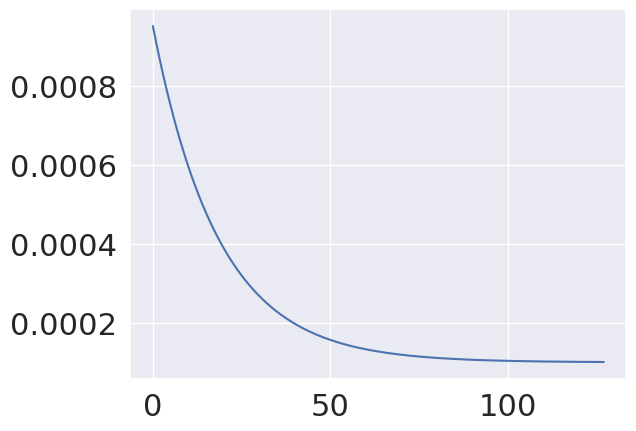

In [14]:
rng = [i for i in range(epochs)]
y = [step_decay(x) for x in rng]
plt.plot(rng, y)
print(f"L'évolution du taux d'apprentissage : du {y[0]:.3g} à {min(y):.3g}")

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Rappels de sauvegarde automatique du modèle </div></b>

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:80%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Sauvegarde chaque étape </div></b>

In [15]:
filename = os.path.join(repertoireSauvegardes, 'modelAutomatic1-epoch-{epoch:04d}.keras')
checkpointTimer1  = tf.keras.callbacks.ModelCheckpoint(filename,save_freq='epoch') 

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:80%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Sauvegarde tous les 5 étapes </div></b>

In [16]:
filename = os.path.join(repertoireSauvegardes, 'modelAutomatic5-epoch-{epoch:04d}.keras')
checkpointTimer5 = tf.keras.callbacks.ModelCheckpoint(filename,save_freq=5) 

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:80%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Sauvegarde si val_loss minim </div></b>

In [17]:
filename = os.path.join(repertoireSauvegardes, 'modelVLoss-epoch-{epoch:04d}-val_loss-{val_loss:0.3f}-val_accuracy-{val_accuracy:0.3f}.keras')

checkpointLoss = tf.keras.callbacks.ModelCheckpoint(filename, 
                                                    monitor = 'val_loss',
                                                    verbose = 1, 
                                                    save_best_only = True, 
                                                    mode = 'min')


### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:80%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Sauvegarde si val_accuracy maxim </div></b>

In [18]:
filename = os.path.join(repertoireSauvegardes, 'modelVAccuracy-epoch-{epoch:04d}-val_loss-{val_loss:0.3f}-val_accuracy-{val_accuracy:0.3f}.keras')
checkpointAccuracy = tf.keras.callbacks.ModelCheckpoint(filename, 
                                                           monitor = 'val_accuracy', 
                                                           verbose = 1, 
                                                           save_best_only = True, 
                                                           mode = 'max')

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:80%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Arrêt de l'apprentissage</div></b>

In [19]:
arretPrecoce = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:80%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Rappels utilisés</div></b>

In [20]:
callbacks = [
    learningRate,
    # checkpointTimer1,
    # checkpointTimer5,
    checkpointLoss,
    # checkpointAccuracy,
    arretPrecoce
]

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Entrainement du modèle</div></b>


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Compilation du modèle </div></b>

In [38]:
np.random.seed(random_seed)
model = make_cnn_model(input_shape=image_size, 
                   num_classes=1, 
                   activation='relu',
                   kernel_initializer=tf.keras.initializers.LecunNormal(random_seed),
                   nb_filtres = 512)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 512)    │        38,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 128)      │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ detection_prob (Dense)          │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,190,081 (15.98 MB)

 Trainable params: 4,187,521 (15.97 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(initial_lrate), 
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
              metrics=[tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                      ])  

In [40]:
start_time = time.time()

model_history = model.fit(pipeline_apprentissage, 
                    validation_data=pipeline_validation, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=callbacks,
                    verbose=2
                   )
print(time.time()-start_time)

Epoch 1/128


I0000 00:00:1751972965.995894 2700557 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.48227, saving model to /home/razvan/documentation/DeepLearning/CNN/07-L'apprentissage et rappels d’exécution--modèle CNN-binaire--Chaussures-TFRecods/repertoire.sauvegardes/modelVLoss-epoch-0001-val_loss-0.482-val_accuracy-0.810.keras
1350/1350 - 14s - 10ms/step - accuracy: 0.8171 - auc: 0.8777 - loss: 0.4444 - precision: 0.8478 - recall: 0.8840 - val_accuracy: 0.8100 - val_auc: 0.9798 - val_loss: 0.4823 - val_precision: 0.7821 - val_recall: 0.9950 - learning_rate: 9.5256e-04
Epoch 2/128

Epoch 2: val_loss improved from 0.48227 to 0.23943, saving model to /home/razvan/documentation/DeepLearning/CNN/07-L'apprentissage et rappels d’exécution--modèle CNN-binaire--Chaussures-TFRecods/repertoire.sauvegardes/modelVLoss-epoch-0002-val_loss-0.239-val_accuracy-0.950.keras
1350/1350 - 9s - 7ms/step - accuracy: 0.9242 - auc: 0.9695 - loss: 0.2839 - precision: 0.9363 - recall: 0.9508 - val_accuracy: 0.9500 - val_auc: 0.9987 - val_loss: 0.2394 - val_precisi

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Affichage historique de l'apprentissage </div></b>

In [41]:
history = sauvegardeHistorique(model_history,
                               repertoireSauvegardes,
                               nomSauvegarde='history_batch_size_32')

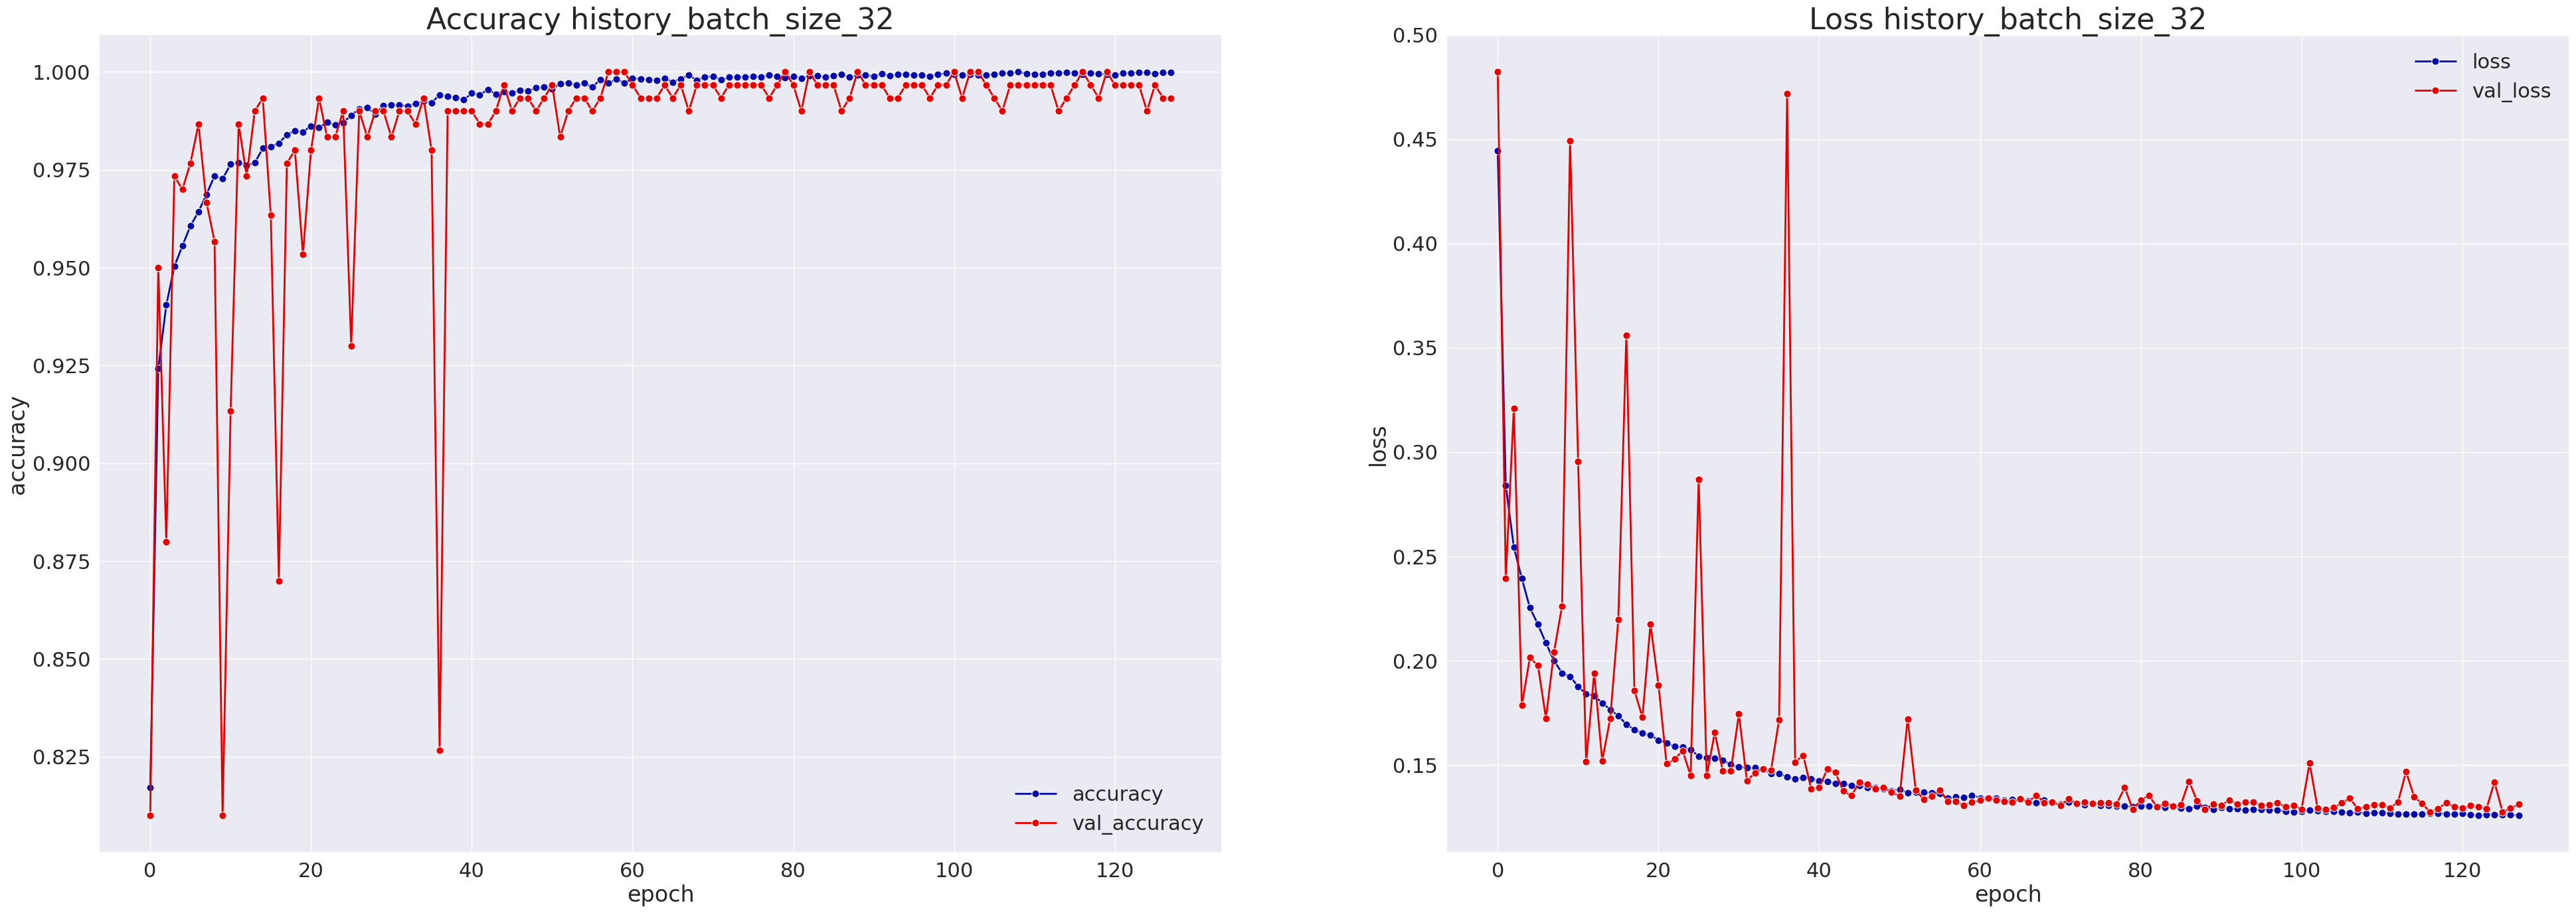

In [42]:
afficheHistoriqueEntrainement(history, palette, 'history_batch_size_32')

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Sauvegarde du modèle </div></b>

In [43]:
model.save(os.path.join(repertoireSauvegardes,'Keras-03-HistoriqueEntrainement.history_batch_size_32.keras'))

In [44]:
sauvegarderModel(model, 'history_batch_size_32')

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Chargement du modèle </div></b>

In [45]:
model = tf.keras.models.load_model(os.path.join(repertoireSauvegardes,'Keras-03-HistoriqueEntrainement.history_batch_size_32.keras'))

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Inférence</div></b>

In [68]:
for i, (img,lab) in enumerate(pipeline_validation):
    if i == 0 : 
        images, labels = img,lab
    else:
        images, labels = tf.concat([images,img], 0), tf.concat([labels,lab], 0)

observations = labels.numpy()

In [74]:
probabilities = model.predict(images, verbose=0).ravel()
predictions = np.round(probabilities).ravel().astype('int8')

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Matrice de Confusion </div></b>

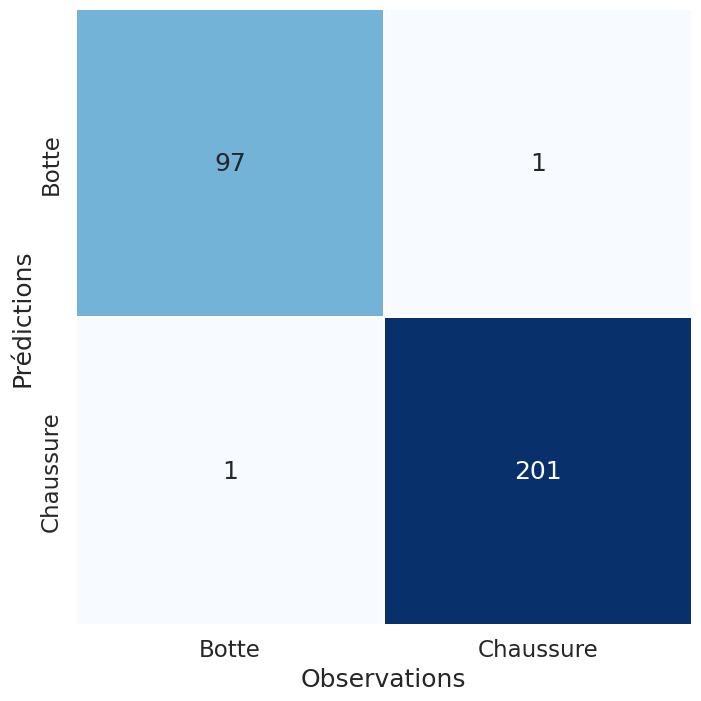

In [75]:
afficheMatriceConfusion(observations=observations,predictions=predictions,dictLabels=dictLabels)

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Résultats de l’apprentissage</div></b>

In [81]:
from sklearn.metrics import roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                            precision_score, recall_score, f1_score, jaccard_score, \
                            precision_recall_curve
def afficheMetrics(observations,predictions):
    accuracy      = accuracy_score  (observations,predictions)
    logloss       = log_loss        (observations,predictions)
    hammingloss   = hamming_loss    (observations,predictions)
    precision     = precision_score (observations,predictions)
    sensibilite   = recall_score    (observations,predictions)
    f1            = f1_score        (observations,predictions)
    jaccard       = jaccard_score   (observations,predictions)
    print(
          " Accuracy           : %.2f%%\n" % (accuracy * 100.0),       
          "logloss            : %.6f\n" % logloss           ,
          "hammingloss        : %.6f\n" % hammingloss       ,
          "precision          : %.6f\n" % precision         ,
          "sensibilite        : %.6f\n" % sensibilite       ,
          "f1                 : %.6f\n" % f1                ,
          "jaccard            : %.6f\n" % jaccard
         )
    return accuracy,logloss,hammingloss,precision,sensibilite,f1,jaccard  

In [83]:
_ = afficheMetrics(observations, predictions)

 Accuracy           : 99.33%
 logloss            : 0.240291
 hammingloss        : 0.006667
 precision          : 0.995050
 sensibilite        : 0.995050
 f1                 : 0.995050
 jaccard            : 0.990148



### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Courbe ROC</div></b>

L'aire sous la courbe ROC : 0.99242271


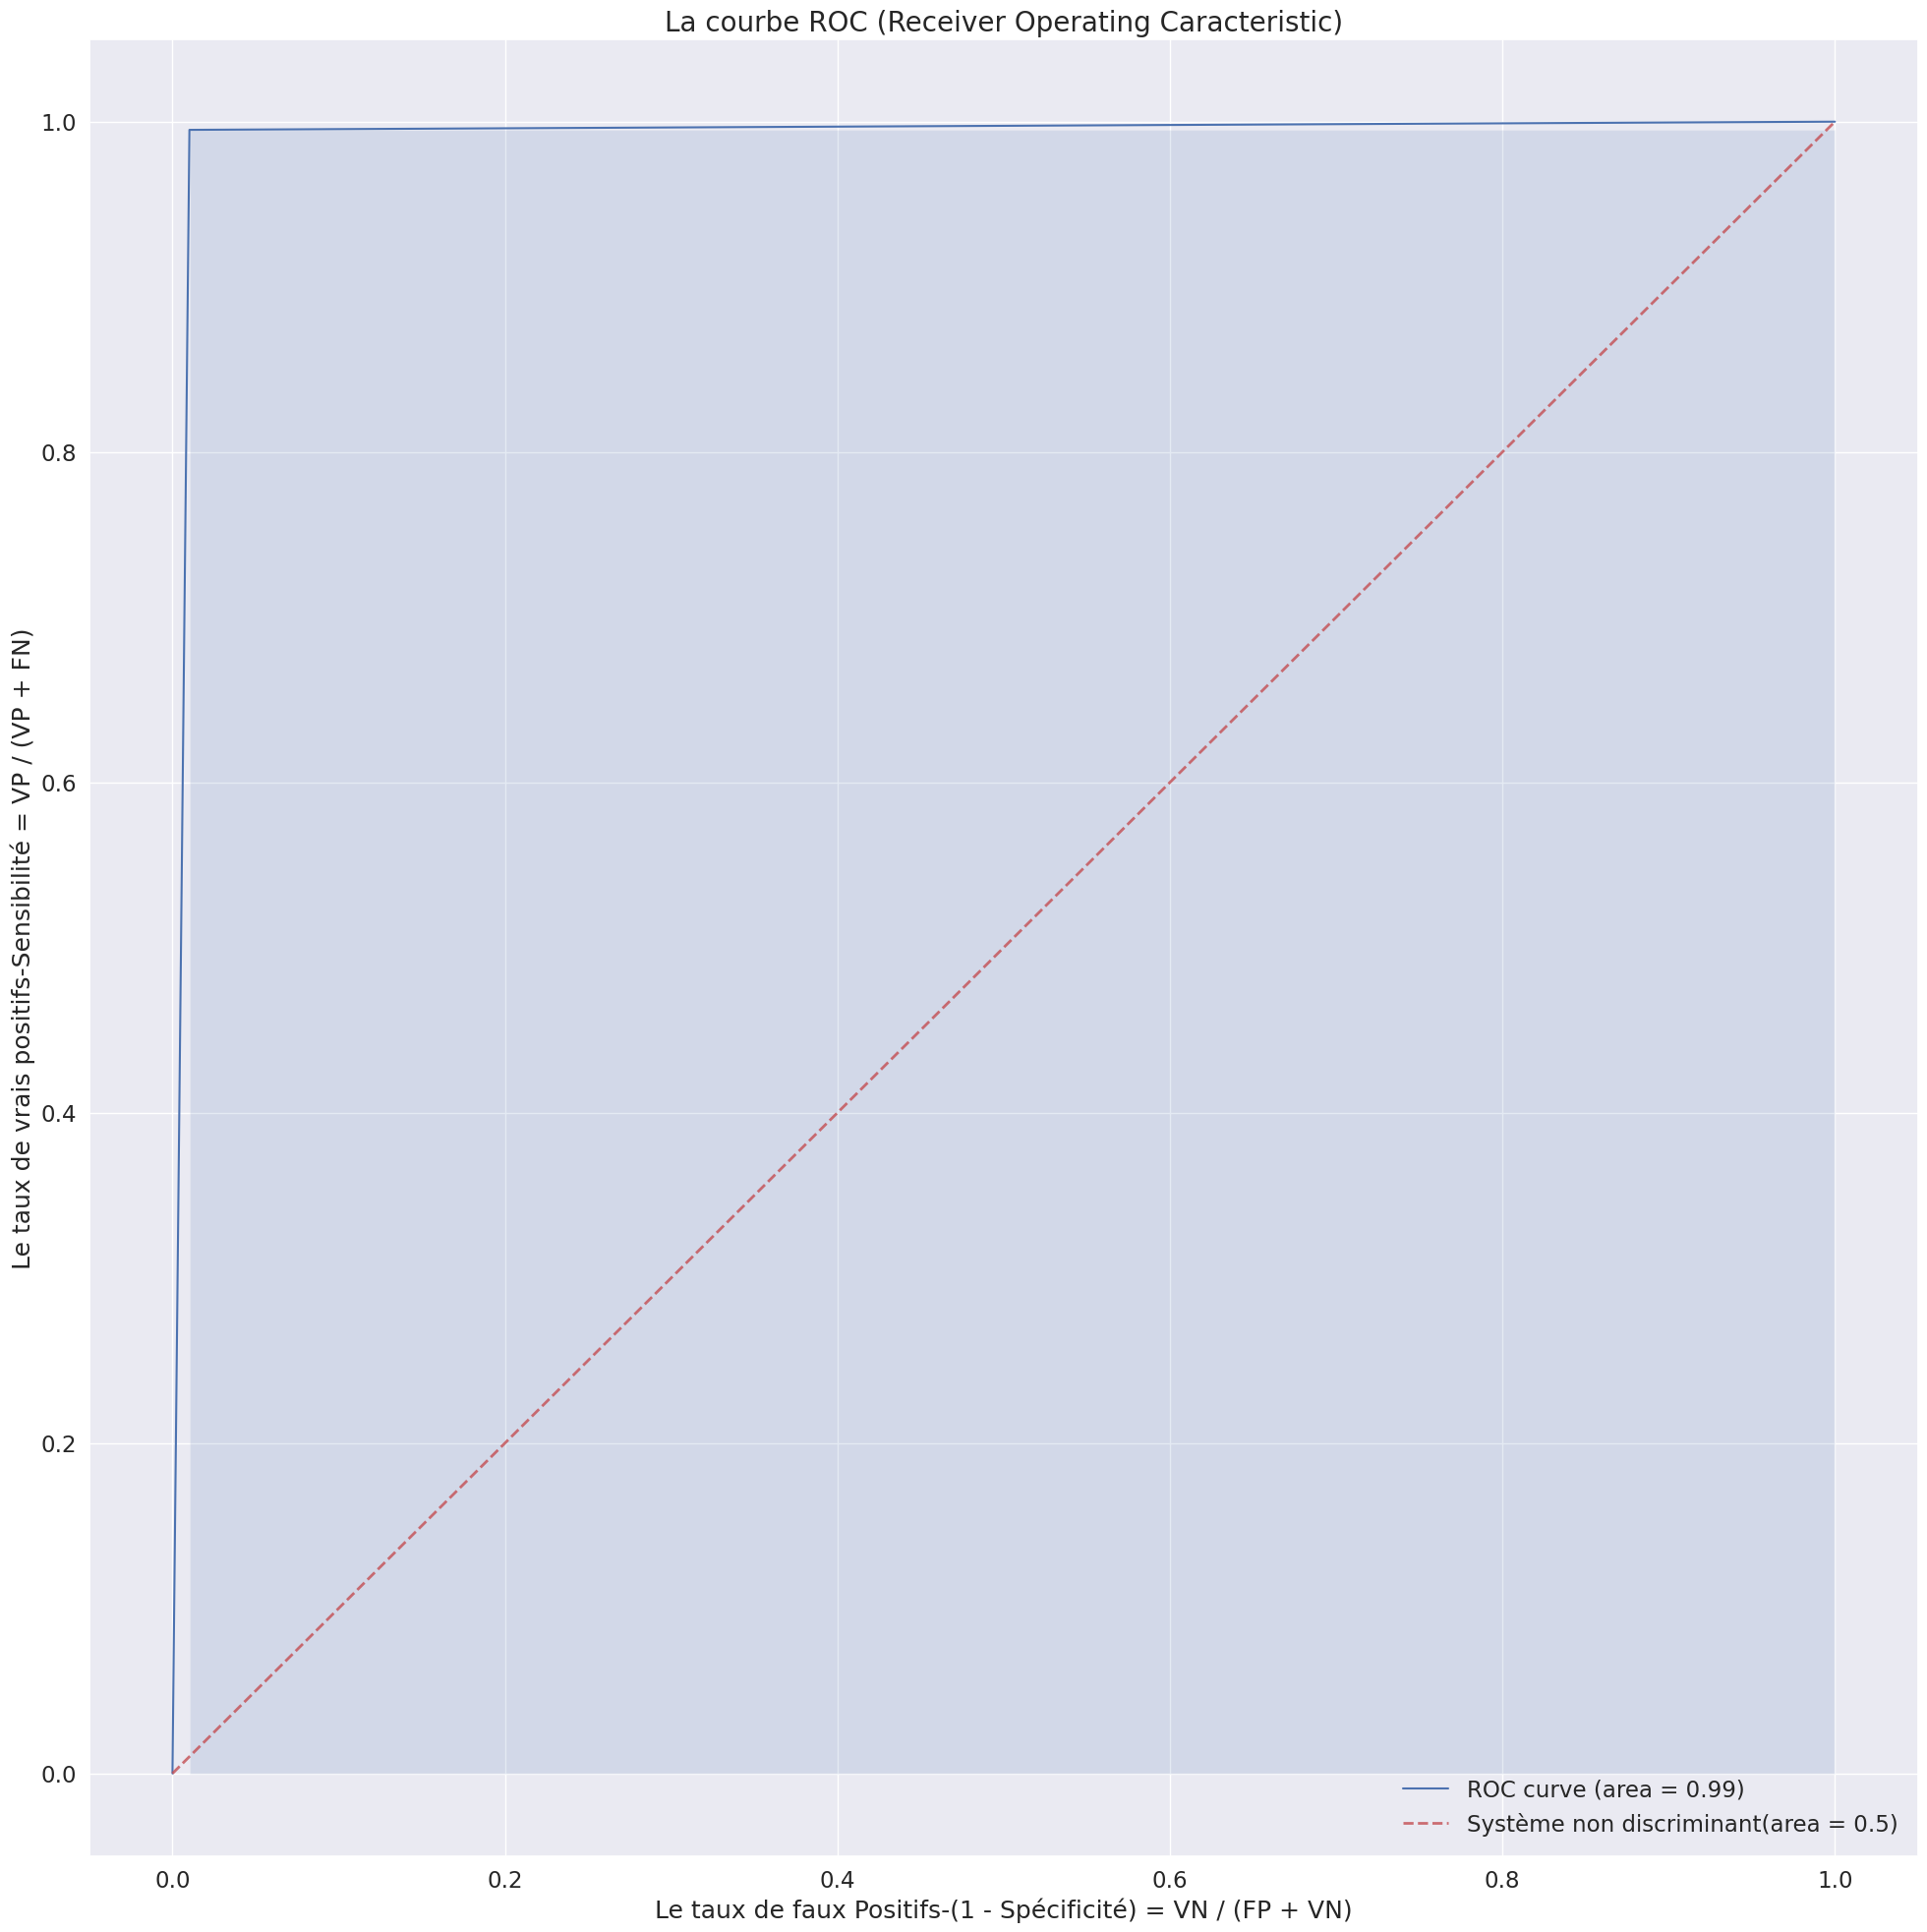

In [80]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score

fpr, tpr, thresholds = roc_curve(observations, predictions)

roc_auc = auc(fpr, tpr)
print (f"L'aire sous la courbe ROC : {roc_auc:.8f}")

plt.figure(figsize=(24,24))
# plt.scatter(fpr, tpr, color='blue')
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, step='post', alpha=0.15)

# plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Système non discriminant(area = 0.5)', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Le taux de faux Positifs-(1 - Spécificité) = VN / (FP + VN)',size=18)
plt.ylabel('Le taux de vrais positifs-Sensibilité = VP / (VP + FN)',size=18)
plt.title('La courbe ROC (Receiver Operating Caracteristic)',size=20)
plt.legend(loc="lower right");

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Courbe Précision-Rappel</div></b>

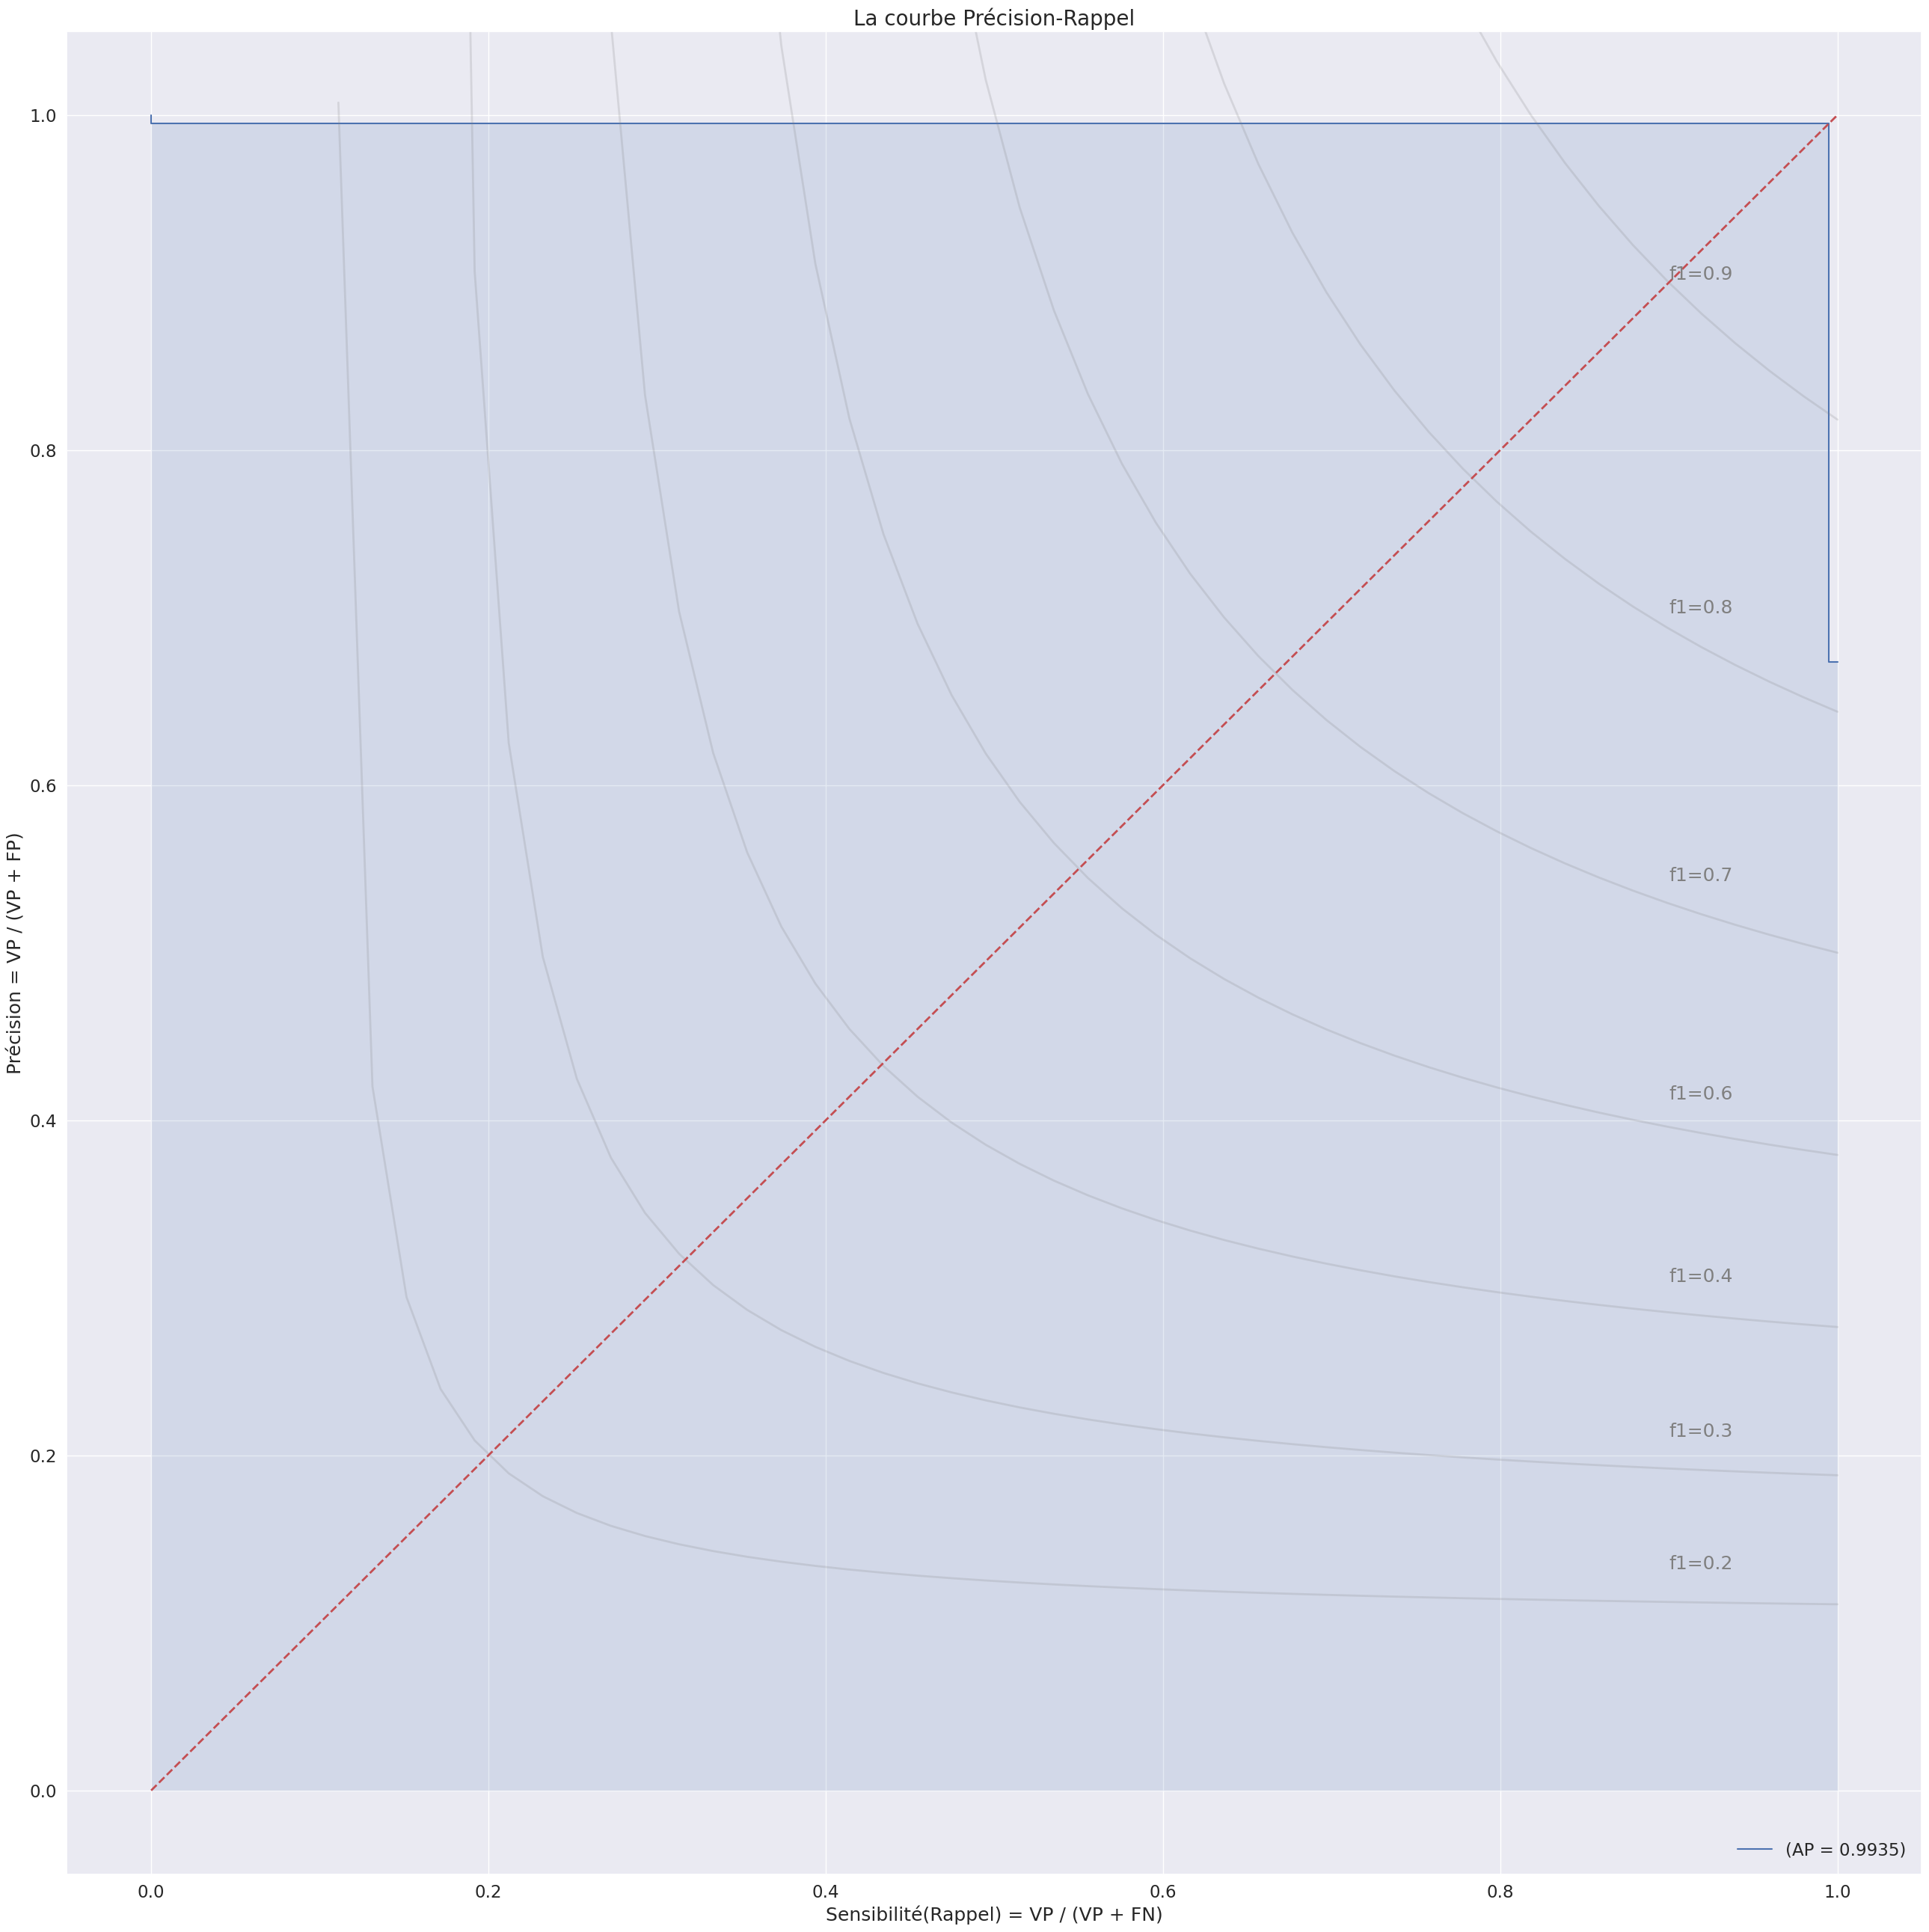

In [78]:
plt.figure(figsize=(32, 32))
prec, rec, tauxPR = precision_recall_curve(observations.ravel(), predictions)
avgPrecRec = average_precision_score(observations.ravel(), predictions)
plt.step(rec, prec, where='post', label=f"(AP = {avgPrecRec:0.4f})")#alpha=0.8, 
plt.fill_between(rec, prec, step='post', alpha=0.15)

f_scores = np.linspace(0.2, 0.9, num=7)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', lw=2, alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02), color='gray')


plt.plot([0, 1], [0, 1], 'k--', lw=2, color='r')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('Sensibilité(Rappel) = VP / (VP + FN)', size=18)
plt.ylabel('Précision = VP / (VP + FP)', size=18)      
plt.title('La courbe Précision-Rappel',size=20)
plt.legend(loc="lower right");